In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import tensorflow as tf
from numpy import *
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from tensorflow.keras import layers,datasets
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
from tensorflow import keras
import gc
# import warnings
# warnings.filterwarnings('ignore')
import lightgbm as lgb
import category_encoders as ce
from sklearn.metrics import f1_score,classification_report,roc_auc_score
from impala.dbapi import connect
from impala.util import as_pandas
import pymysql

In [2]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [3]:
def get_game_id():
    conn = pymysql.connect(host='192.168.0.79', port=3306, user='readonly',
                           passwd='Kc&r+z1ql9x8za4kzfk761weq8ozGv3ZpI;RMe,#+s%c>t')
    cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
    sql = '''
        SELECT dev_game_id AS game_id FROM db_data.t_game_config WHERE game_id = 1112 AND dev_game_id IS NOT NULL 
    '''
    cur.execute(sql)
    result_df = cur.fetchall()
    cur.close()
    conn.close()
    return result_df

In [4]:
# 获取近期所有计划('2021年5月7号开始')
def get_plan_info():
    game_id = get_game_id()
    game_id = list(map(lambda x: x['game_id'], game_id))
    game_id = [str(i) for i in game_id]
    game_id = ','.join(game_id)
    conn = pymysql.connect(host='192.168.0.65', port=3306, user='readonly',
                           passwd='Kc&r+z1ql9x8za4kzfk761weq8ozGv3ZpI;RMe,#+s%c>t', db='db_ptom')
    cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
    sql = '''
    /*手动查询*/
        SELECT
                * 
            FROM
                db_ptom.ptom_third_plan p
            WHERE
                game_id IN ({})
                AND media_id = 10
                AND create_time>='2021-05-07'
                AND create_time<= date(NOW())
                            AND plan_id >= (
                                select plan_id from db_ptom.ptom_plan
                                where create_time >= '2021-05-07'
                                and create_time <= '2021-05-08'
                                limit 1
                            )
    '''
    finalSql = sql.format(game_id)
    result_df = pd.read_sql(finalSql, conn)
    cur.close()
    conn.close()
    return result_df

In [5]:
# 获取image_id,label_ids
def get_image_info():
    conn = pymysql.connect(host='192.168.0.79', port=3306, user='readonly',
                        passwd='Kc&r+z1ql9x8za4kzfk761weq8ozGv3ZpI;RMe,#+s%c>t')
    cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
    sql = '''
        SELECT
            a.chl_user_id AS channel_id,
            a.source_id,
            a.image_id,
            b.label_ids
        FROM
            db_data_ptom.ptom_plan a
            LEFT JOIN
            db_data_ptom.ptom_image_info b
        on a.image_id = b.image_id
        WHERE
            a.game_id IN ( SELECT dev_game_id AS game_id FROM db_data.t_game_config WHERE game_id = 1112 AND dev_game_id IS NOT NULL ) 
            AND a.media_id = 10 
            AND a.create_time >= '2020-12-01' 
        GROUP BY
            a.chl_user_id,
            a.source_id,
            a.image_id
    '''
    cur.execute(sql)
    result_df = pd.read_sql(sql, conn)
    cur.close()
    conn.close()
    return result_df

In [6]:
def get_launch_report():
    game_id = get_game_id()
    game_id = list(map(lambda x: x['game_id'], game_id))
    game_id = [str(i) for i in game_id]
    game_id = ','.join(game_id)

    conn = pymysql.connect(host='192.168.0.79', port=3306, user='readonly',
                           passwd='Kc&r+z1ql9x8za4kzfk761weq8ozGv3ZpI;RMe,#+s%c>t')
    cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
    sql = '''
        /*手动查询*/
        SELECT
            a.chl_user_id AS channel_id,
            a.source_id AS source_id,
            b.tdate,
            b.amount,
            b.new_role_money,
            b.new_role_money / b.amount as roi,
            b.pay_role_user_num / b.create_role_num as pay_rate
        FROM
            db_data_ptom.ptom_plan a
            LEFT JOIN db_stdata.st_lauch_report b ON a.chl_user_id = b.channel_id 
            AND a.source_id = b.source_id 
        WHERE
            a.create_time >= '2020-12-01' 
            AND b.tdate >= '2020-12-01' 
            AND b.tdate_type = 'day' 
            AND b.media_id = 10
            AND b.game_id IN ({})
            AND b.amount >= 500
    '''
    finalSql = sql.format(game_id)
    cur.execute(finalSql)
    result_df = pd.read_sql(finalSql, conn)
    cur.close()
    conn.close()
    result_df['tdate'] = pd.to_datetime(result_df['tdate'])
    result_df = result_df.sort_values('tdate')
    result_df = result_df.drop_duplicates(['channel_id', 'source_id'], keep='first')

    return result_df

In [7]:
# 解析json
def get_plan_json(plan_info):
    plan_info.drop(['inventory_type','budget'], axis=1, inplace=True)
    plan_info.dropna(how='all', inplace=True, axis=1)
    plan_info.dropna(subset=['ad_info'],inplace=True)
    # 解析json
    plan_info['ad_info'] = plan_info['ad_info'].apply(json.loads)
    temp = plan_info['ad_info'].apply(pd.Series)
    plan_info = pd.concat([plan_info,temp], axis=1)
    plan_info.drop('ad_info', axis=1, inplace=True)
    temp = plan_info['audience'].apply(pd.Series)
    plan_info = pd.concat([plan_info,temp], axis=1)
    plan_info.drop('audience', axis=1, inplace=True)
    temp = plan_info['action'].apply(pd.Series)
    plan_info = pd.concat([plan_info,temp], axis=1)
    plan_info.drop('action', axis=1, inplace=True)
    plan_info.dropna(how='all', inplace=True, axis=1)
    plan_info = plan_info[['ad_account_id', 'game_id', 'channel_id', 'source_id',
           'create_time', 'smart_bid_type', 'hide_if_exists', 'budget',
           'delivery_range', 'adjust_cpa', 'inventory_type', 'hide_if_converted',
           'flow_control_mode', 'schedule_time', 'cpa_bid', 'auto_extend_enabled',
           'gender', 'city', 'platform', 'launch_price',
           'retargeting_tags_exclude', 'interest_categories',
           'ac', 'android_osv', 'location_type', 'retargeting_tags_include',
           'retargeting_type', 'ios_osv', 'interest_action_mode', 'age',
           'action_categories', 'action_days', 'action_scene','deep_bid_type','roi_goal']]
    return plan_info

In [8]:
def get_all_data():
    # 读取历史数据
    plan_info = pd.read_csv('./hist_data/ptom_third_plan.csv')
#     image_info = pd.read_csv('./hist_data/image_info.csv')
#     launch_report = pd.read_csv('./hist_data/launch_report.csv')
    
    plan_info_new = get_plan_info()
    image_info = get_image_info()
    launch_report = get_launch_report()
    
    plan_info = plan_info.append(plan_info_new)
    plan_info = get_plan_json(plan_info)
#     image_info = image_info.append(image_info_new)
#     launch_report = launch_report.append(launch_report_new)
    image_info.dropna(subset=['image_id'],inplace=True)
    image_info['image_id'] = image_info['image_id'].astype(int)
    return plan_info,image_info,launch_report

In [9]:
plan_info,image_info,launch_report = get_all_data()

In [10]:
plan_info.shape

(42259, 35)

### 构造新计划

In [11]:
# 获取score_image ()
def get_score_image():
    conn = connect(host='192.168.0.88', port=10000, auth_mechanism='PLAIN', user='hadoop',
                    password='Ycjh8FxiaoMtShZRd3-97%3hCEL0CK4ns1w', database='default')
    cursor = conn.cursor()
    sql_engine = 'set hive.execution.engine=tez'
    sql = 'select image_id,label_ids from dws.dws_image_score_d where media_id=10 and score>=550 and dt=CURRENT_DATE group by image_id,label_ids'
    cursor.execute(sql_engine)
    cursor.execute(sql)
    result = as_pandas(cursor)
    result['label_ids'] = result['label_ids'].astype(str)
    result['label_ids'] = result['label_ids'].apply(lambda x: x.strip('-1;') if '-1' in x else x)
    result['label_ids'] = pd.to_numeric(result['label_ids'],errors='coerce')

    # 关闭链接
    cursor.close()
    conn.close()
    
    return result['image_id'].values

In [12]:
plan_info['create_time'] = pd.to_datetime(plan_info['create_time'])
plan_info_current = plan_info[plan_info['create_time']>=pd.datetime.now() - pd.DateOffset(8)]

C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [13]:
# 获取近期计划的运营数据
def get_now_plan_roi():
    game_id = get_game_id()
    game_id = list(map(lambda x: x['game_id'], game_id))
    game_id = [str(i) for i in game_id]
    game_id = ','.join(game_id)

    conn = pymysql.connect(host='192.168.0.79', port=3306, user='readonly',
                           passwd='Kc&r+z1ql9x8za4kzfk761weq8ozGv3ZpI;RMe,#+s%c>t')
    cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
    sql = '''
        SELECT
          b.channel_id,
          b.source_id,
            b.tdate,
            b.amount,
            b.new_role_money,
            b.new_role_money / b.amount AS roi,
            b.pay_role_user_num / b.create_role_num AS pay_rate 
        FROM
            db_stdata.st_lauch_report b
        WHERE
            b.tdate >= date( NOW() - INTERVAL 120 HOUR ) 
            AND b.tdate_type = 'day' 
            AND b.media_id = 10 
            AND b.game_id IN ({}) 
            AND b.amount >= 500 
            AND b.pay_role_user_num >= 2 
            AND b.new_role_money >= 90
            AND (b.new_role_money / b.amount)>=0.03
    '''
    finalSql = sql.format(game_id)
    cur.execute(finalSql)
    result_df = pd.read_sql(finalSql, conn)
    cur.close()
    conn.close()
    result_df['tdate'] = pd.to_datetime(result_df['tdate'])
    result_df = result_df.sort_values('tdate')
    result_df = result_df.drop_duplicates(['channel_id', 'source_id'], keep='first')
#     result_df = result_df[result_df['roi'] >= 0.03]
    return result_df

In [14]:
# 获取近期优化计划的创意数据
def get_creative():
    game_id = get_game_id()
    game_id = list(map(lambda x: x['game_id'], game_id))
    game_id = [str(i) for i in game_id]
    game_id = ','.join(game_id)

    conn = pymysql.connect(host='192.168.0.65', port=3306, user='readonly',
                           passwd='Kc&r+z1ql9x8za4kzfk761weq8ozGv3ZpI;RMe,#+s%c>t')
    cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
    sql = '''
        /*手动查询*/ 
        SELECT
            b.chl_user_id AS channel_id,
            b.source_id,
            JSON_EXTRACT( a.creative_param, '$.ad_keywords' ) AS ad_keywords,
            JSON_EXTRACT( a.creative_param, '$.title_list' ) AS title_list,
            JSON_EXTRACT( a.creative_param, '$.third_industry_id' ) AS third_industry_id 
        FROM
            db_ptom.ptom_batch_ad_task a
            LEFT JOIN db_ptom.ptom_plan b ON a.plan_name = b.plan_name 
        WHERE
            a.media_id = 10 
            AND b.create_time >= date( NOW() - INTERVAL 720 HOUR )    # 近30天
            AND a.game_id IN ({}) 
    '''
    finalSql = sql.format(game_id)
    cur.execute(finalSql)
    result = pd.read_sql(finalSql, conn)
    cur.close()
    conn.close()
    return result

In [15]:
creative_info = get_creative()
creative_info['title_list'] = creative_info['title_list'].fillna('[]')
creative_info['ad_keywords'] = creative_info['ad_keywords'].fillna('[]')
creative_info['title_list'] = creative_info['title_list'].apply(json.loads)
creative_info['ad_keywords'] = creative_info['ad_keywords'].apply(json.loads)

In [16]:
now_plan_roi = get_now_plan_roi()
now_plan_roi = pd.merge(now_plan_roi,creative_info,on=['channel_id','source_id'],how='left')

In [17]:
now_plan_roi.head()

,channel_id,source_id,tdate,amount,new_role_money,roi,pay_rate,ad_keywords,title_list,third_industry_id
0,6231,634667,2021-05-15,8005.87,336.0,0.041969,0.0345,"[游戏, 战争游戏, 策略游戏, 新闻热点]","[{'title': '小时候玩的帝国终于出手游了！开局5个农民，建立你的帝国！', 'cr...",19131201
1,21146,646010,2021-05-15,2761.48,121.0,0.043817,0.0235,"[英雄联盟, 万国觉醒, 三国游戏, 战略, 体育, 三国, 文明6, 帝国, 魔兽争霸3,...","[{'title': '苦等20年，帝国终于出手游了！满满的儿时回忆，老玩家已感动哭！', ...",19131201
2,21318,644906,2021-05-15,2358.62,440.0,0.186550,0.0625,"[帝国, 文明, 美女, 长腿, 小姨子, 女忧, 豪车, 科技, 5G, 科普, 历史, ...","[{'title': '三大阵营，谁会是你的时代！', 'creative_word_ids...",19131401
3,21316,646142,2021-05-15,2143.68,113.0,0.052713,0.0476,"[游戏, 手游, 帝国, SLG, 文明, 铁甲, 列王的纷争, COK, 万国觉醒, 策略...","[{'title': '苦等20年，帝国终于出手游了！满满的儿时回忆，老玩家已感动哭！', ...",19131201
4,21297,641512,2021-05-15,7264.54,1298.0,0.178676,0.1000,"[三国志, 帝国, 策略手游, 战争策略, 传奇, 万国觉醒, 策略游戏, 红色警戒, 军队...","[{'title': '全球SLG玩家的选择：真实兵种自由搭配，成败靠脑不靠肝！', 'cr...",19131201


In [18]:
now_plan_roi.shape

(47, 10)

In [19]:
score_image = get_score_image()

In [20]:
score_image

array([30438, 31184, 31277, 31363, 31408, 31642, 32030, 32171, 32187,
       32284, 32633, 32719, 33022, 33024, 33025, 33099, 33115, 33134,
       33285, 33315, 33348, 33429, 33437, 33547, 33551, 33559],
      dtype=int64)

In [21]:
image_info.head()

,channel_id,source_id,image_id,label_ids
1,6231,476667,29773,"117,120"
2,6231,476668,29249,124
3,6231,476669,29793,117
4,6231,476670,29339,124
5,6231,476671,29920,124


In [22]:
df_create = pd.merge(plan_info_current,image_info,on=['channel_id','source_id'],how='left')
df_create = pd.merge(df_create,now_plan_roi,on=['channel_id','source_id'],how='inner')
df_create['platform'] = df_create['platform'].astype(str)
df_create['platform'] = df_create['platform'].map({"['ANDROID']":1,"['IOS']":2})
df_create['platform'] = df_create['platform'].astype(int)

In [23]:
df_create.dropna(subset=['image_id'],inplace=True)
df_create['image_id'] = df_create['image_id'].astype(int)

In [24]:
df_create = df_create[df_create['platform']==1]

In [25]:
df_create.shape

(39, 45)

In [26]:
df_create.head()

,ad_account_id,game_id,channel_id,source_id,create_time,smart_bid_type,hide_if_exists,budget,delivery_range,adjust_cpa,inventory_type,hide_if_converted,flow_control_mode,schedule_time,cpa_bid,auto_extend_enabled,gender,city,platform,launch_price,retargeting_tags_exclude,interest_categories,ac,android_osv,location_type,retargeting_tags_include,retargeting_type,ios_osv,interest_action_mode,age,action_categories,action_days,action_scene,deep_bid_type,roi_goal,image_id,label_ids,tdate,amount,new_role_money,roi,pay_rate,ad_keywords,title_list,third_industry_id
1,7504,1001619,21297,641512,2021-05-13 10:20:38,SMART_BID_CUSTOM,0,3700.0,DEFAULT,0.0,"[INVENTORY_HOTSOON_FEED, INVENTORY_TOMATO_NOVE...",APP,FLOW_CONTROL_MODE_FAST,0000000000000000000000000000000000000000000000...,651.19,0,GENDER_MALE,"[64, 421000, 11, 12, 13, 14, 15, 422800, 42050...",1,"[0, 11000]",[],[],[],7.0,HOME,[],NONE,NONE,RECOMMEND,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,BID_PER_ACTION,NaN,30503,130,2021-05-15,7264.54,1298.0,0.178676,0.1000,"[三国志, 帝国, 策略手游, 战争策略, 传奇, 万国觉醒, 策略游戏, 红色警戒, 军队...","[{'title': '全球SLG玩家的选择：真实兵种自由搭配，成败靠脑不靠肝！', 'cr...",19131201
2,6616,1001619,21146,644058,2021-05-14 11:13:37,SMART_BID_CUSTOM,0,2000.0,DEFAULT,0.0,[INVENTORY_AWEME_FEED],AD,FLOW_CONTROL_MODE_FAST,1111111111111111111111111111111111111111111111...,589.14,0,GENDER_MALE,[],1,"[0, 11000]",[],[],[],NONE,CURRENT,[],NaN,NONE,RECOMMEND,"[AGE_BETWEEN_18_23, AGE_BETWEEN_24_30, AGE_BET...",NaN,NaN,NaN,BID_PER_ACTION,NaN,33134,-1,2021-05-16,8493.42,1224.0,0.144112,0.0909,"[英雄联盟, 万国觉醒, 三国游戏, 战略, 体育, 三国, 文明6, 帝国, 魔兽争霸3,...","[{'title': '帝国手游今日公测！建筑，开矿，扩张，建立属于自己的帝国！', 'cr...",19131201
3,6617,1001619,21146,644061,2021-05-14 11:13:39,SMART_BID_CUSTOM,0,2000.0,DEFAULT,0.0,[INVENTORY_AWEME_FEED],AD,FLOW_CONTROL_MODE_FAST,1111111111111111111111111111111111111111111111...,589.64,0,GENDER_MALE,[],1,"[0, 11000]",[],[],[],NONE,CURRENT,[],NaN,NONE,RECOMMEND,"[AGE_BETWEEN_18_23, AGE_BETWEEN_24_30, AGE_BET...",NaN,NaN,NaN,BID_PER_ACTION,NaN,33134,-1,2021-05-16,2953.63,270.0,0.091413,0.0769,"[英雄联盟, 万国觉醒, 三国游戏, 战略, 体育, 三国, 文明6, 帝国, 魔兽争霸3,...","[{'title': '帝国手游今日公测！建筑，开矿，扩张，建立属于自己的帝国！', 'cr...",19131201
4,6023,1001545,6231,644114,2021-05-14 11:20:36,SMART_BID_CUSTOM,0,3500.0,DEFAULT,0.0,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]",AD,FLOW_CONTROL_MODE_FAST,1111111111111111111111111111111111111111111111...,488.88,0,GENDER_MALE,"[11, 12, 13, 14, 15, 21, 22, 23, 31, 32, 33, 3...",1,"[0, 11000]",[],[],"[WIFI, 4G]",7.0,HOME,[],NaN,NONE,RECOMMEND,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,BID_PER_ACTION,NaN,32633,"114,117",2021-05-15,7476.64,381.0,0.050959,0.0361,"[游戏, 战争游戏, 策略游戏, 新闻热点]","[{'title': '小时候玩的帝国终于出手游了！开局5个农民，建立你的帝国！', 'cr...",19131201
5,6744,1001619,21146,644253,2021-05-14 11:31:36,SMART_BID_CUSTOM,0,10000.0,UNION,0.0,[INVENTORY_UNION_SLOT],AD,FLOW_CONTROL_MODE_FAST,1111111111111111111111111111111111111111111111...,666.80,0,NONE,"[64, 421000, 11, 12, 13, 14, 15, 422800, 42050...",1,"[0, 11000]",[],[],[],NONE,CURRENT,[],NONE,NONE,RECOMMEND,[],NaN,NaN,NaN,BID_PER_ACTION,NaN,33025,"129,130,134,138,133,132",2021-05-17,9314.32,461.0,0.049494,0.0750,"[英雄联盟, 万国觉醒, 三国游戏, 战略, 体育, 三国, 文明6, 帝国, 魔兽争霸3,...","[{'title': '苦等20年，帝国终于出手游了！满满的儿时回忆，老玩家已感动哭！', ...",19131201


In [27]:
df_create['game_id'].value_counts()

1001545    18
1001619     7
1001635     3
1001469     2
1001685     2
1001667     2
1001655     1
1001683     1
1001680     1
1001668     1
1001493     1
Name: game_id, dtype: int64

In [28]:
def create_plan(df, score_image):
    # 选ad_account_id、image_id每个账号+素材8条
    ad_account_id_group = np.array([7590, 7591, 7592, 7593, 7594])
    image_id_group = np.intersect1d(df['image_id'].unique(), score_image)
    print(image_id_group)
    df = df[df['deep_bid_type'].isin(['BID_PER_ACTION', 'ROI_COEFFICIENT'])]
    df = df[df['image_id'].isin(image_id_group)]
    game_id = 1001673
#     df = df[df['game_id'] == game_id]

    plan = pd.DataFrame()
    for ad_account in ad_account_id_group:
        for image in image_id_group:
            #         print(image)
            temp = pd.DataFrame({'ad_account_id': [ad_account], 'image_id': [image]})
            plan = plan.append(temp)
    #         print(temp)
    plan = pd.DataFrame(np.repeat(plan.values, 10, axis=0), columns=plan.columns)

    # game_image = df[['game_id', 'image_id']].drop_duplicates()
    # plan = pd.merge(plan, game_image, on='image_id', how='left')
    plan['game_id'] = game_id

    # 选platform测试期默认[ANDROID]
    plan['platform'] = df['platform'].iloc[0]
    plan['platform'] = plan['platform'].apply(lambda x: '[ANDROID]' if x == 1 else '[IOS]')

    # 选android_osv
    count_df = pd.DataFrame(data=df['android_osv'].value_counts()).reset_index()
    count_df.columns = ['col', 'counts']
    count_df['pct'] = count_df['counts'] / count_df['counts'].sum()
    plan['android_osv'] = plan['platform'].apply(lambda x: 'NONE' if x == '[IOS]' else
    np.random.choice(count_df['col'].values, 1, p=count_df['pct'].values)[0])

    # 选ios_osv
    count_df = pd.DataFrame(data=df['ios_osv'].value_counts()).reset_index()
    count_df.columns = ['col', 'counts']
    count_df['pct'] = count_df['counts'] / count_df['counts'].sum()
    plan['ios_osv'] = plan['platform'].apply(lambda x: 'NONE' if x == '[ANDROID]' else
    np.random.choice(count_df['col'].values, 1, p=count_df['pct'].values)[0])

    # 选budget
    plan['budget'] = plan['platform'].apply(lambda x: 3300 if x == '[ANDROID]' else 4000)

    # 选'ad_keywords', 'title_list', 'third_industry_id'  创意
    sample_df = df[['ad_keywords', 'title_list', 'third_industry_id']]
    sample_df = sample_df.sample(n=plan.shape[0], replace=True).reset_index(drop=True)
    plan = pd.concat([plan, sample_df], axis=1)

    # 选'retargeting_type','retargeting_tags_include','retargeting_tags_exclude'  人群包定向
    sample_df = df[['retargeting_type', 'retargeting_tags_include', 'retargeting_tags_exclude']]
    sample_df = sample_df.sample(n=plan.shape[0], replace=True).reset_index(drop=True)
    plan = pd.concat([plan, sample_df], axis=1)

    # 选'interest_action_mode','action_scene','action_days','action_categories' ,'interest_categories' 行为兴趣
    sample_df = df[['interest_action_mode', 'action_scene', 'action_days', 'action_categories', 'interest_categories']]
    sample_df = sample_df.sample(n=plan.shape[0], replace=True).reset_index(drop=True)
    plan = pd.concat([plan, sample_df], axis=1)

    # 选'deep_bid_type','roi_goal','smart_bid_type','adjust_cpa','cpa_bid'出价方式
    sample_df = df[['deep_bid_type', 'roi_goal', 'smart_bid_type', 'adjust_cpa', 'cpa_bid']]
    sample_df = sample_df[sample_df['deep_bid_type'].isin(['ROI_COEFFICIENT', 'BID_PER_ACTION'])]
    sample_df = sample_df.sample(n=plan.shape[0], replace=True).reset_index(drop=True)
    plan = pd.concat([plan, sample_df], axis=1)

    # 选
    cols = ['delivery_range', 'city', 'location_type', 'gender', 'age', 'ac', 'launch_price',
            'auto_extend_enabled', 'hide_if_exists', 'hide_if_converted', 'schedule_time', 'flow_control_mode']
    for col in cols:
        count_df = pd.DataFrame(data=df[col].value_counts()).reset_index()
        count_df.columns = ['col', 'counts']
        count_df['pct'] = count_df['counts'] / count_df['counts'].sum()
        plan[col] = plan.apply(lambda x: np.random.choice(count_df['col'].values, 1, p=count_df['pct'].values)[0],
                               axis=1)

    # 选inventory_type 创意投放位置
    count_df = pd.DataFrame(data=df['inventory_type'].value_counts()).reset_index()
    count_df.columns = ['col', 'counts']

    for i in range(count_df.shape[0]):
        values = count_df.loc[i, 'col']

        for value in values:
            if value == None:
                values.remove(value)
        a = np.empty(1, dtype=object)
        a[0] = values
        count_df.loc[i, 'col'] = a
    count_df['pct'] = count_df['counts'] / count_df['counts'].sum()
    plan['inventory_type'] = plan.apply(
        lambda x: np.random.choice(count_df['col'].values, 1, p=count_df['pct'].values)[0], axis=1)
    plan['create_time'] = pd.to_datetime(pd.datetime.now())
    plan['create_date'] = pd.to_datetime(pd.datetime.now().date())

    return plan

In [29]:
plan_create = create_plan(df_create, score_image)

[31184 31642 32633 32719 33025 33099 33134 33285 33315 33437 33547]


C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel_launcher.py:92: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel_launcher.py:93: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


In [30]:
plan_create.shape

(550, 38)

In [31]:
plan_create['image_id'].value_counts()

32719    50
31642    50
32633    50
33547    50
33437    50
33315    50
33285    50
31184    50
33134    50
33099    50
33025    50
Name: image_id, dtype: int64

In [32]:
plan_create.head()

,ad_account_id,image_id,game_id,platform,android_osv,ios_osv,budget,ad_keywords,title_list,third_industry_id,retargeting_type,retargeting_tags_include,retargeting_tags_exclude,interest_action_mode,action_scene,action_days,action_categories,interest_categories,deep_bid_type,roi_goal,smart_bid_type,adjust_cpa,cpa_bid,delivery_range,city,location_type,gender,age,ac,launch_price,auto_extend_enabled,hide_if_exists,hide_if_converted,schedule_time,flow_control_mode,inventory_type,create_time,create_date
0,7590,31184,1001673,[ANDROID],NONE,NONE,3300,"[游戏, 手游, 对战, 军事手游, 三国志, 三国志策略版, 万国觉醒, 传奇, 深蓝战舰...","[{'title': '苦等20年，帝国终于出手游了！采集伐木，挖矿，打造你的帝国！', '...",19131201,NaN,[],[],RECOMMEND,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,564.57,DEFAULT,"[11, 12, 13, 14, 15, 21, 22, 23, 31, 32, 33, 3...",CURRENT,GENDER_MALE,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...","[WIFI, 4G]","[0, 11000]",0,0,APP,1111111111111111111111111111111111111111110000...,FLOW_CONTROL_MODE_FAST,[INVENTORY_AWEME_FEED],2021-05-20 15:31:05.227622,2021-05-20
1,7590,31184,1001673,[ANDROID],NONE,NONE,3300,"[游戏, 手游, 帝国, SLG, 文明铁甲, 列王的纷争, COK, 万国觉醒, 策略, ...","[{'title': '开局被踢飞，你能打造出最强帝国么？', 'creative_word...",19131201,NaN,[],[],RECOMMEND,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,588.88,DEFAULT,"[11, 12, 13, 14, 15, 21, 22, 23, 31, 32, 33, 3...",HOME,GENDER_MALE,"[AGE_BETWEEN_18_23, AGE_BETWEEN_24_30, AGE_BET...",[],"[0, 11000]",0,0,AD,1111111111111111111111111111111111111111100000...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]",2021-05-20 15:31:05.227622,2021-05-20
2,7590,31184,1001673,[ANDROID],7.0,NONE,3300,"[手游, SLG, 策略, 战争策略, 策略手游, 最强王者, 我的使命, 红警, 帝国文明...","[{'title': '开局流落荒岛，填海造陆，挖矿伐木，白手起家，建立海岛王国！', 'c...",19131201,NONE,[],[],RECOMMEND,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,625.16,DEFAULT,[],CURRENT,GENDER_MALE,[],[],"[0, 11000]",0,1,AD,1111111111111111111111111111111111111111111111...,FLOW_CONTROL_MODE_FAST,[INVENTORY_AWEME_FEED],2021-05-20 15:31:05.227622,2021-05-20
3,7590,31184,1001673,[ANDROID],8.0,NONE,3300,"[游戏, 战争游戏, 策略游戏, 新闻热点]","[{'title': '小时候玩的帝国终于出手游了！开局5个农民，建立你的帝国！', 'cr...",19131201,NONE,[],[],RECOMMEND,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,568.88,DEFAULT,[],CURRENT,GENDER_MALE,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",[],"[0, 11000]",0,0,APP,0000000000000000000000111111111111111111111111...,FLOW_CONTROL_MODE_FAST,[INVENTORY_AWEME_FEED],2021-05-20 15:31:05.227622,2021-05-20
4,7590,31184,1001673,[ANDROID],7.0,NONE,3300,"[三国志, 帝国, 策略手游, 战争策略, 传奇, 万国觉醒, 策略游戏, 红色警戒, 军队...","[{'title': '练兵、种植、升级建筑，还要防止领国的入侵，这是你的帝国之战！', '...",19131201,NaN,[],"[317227650, 321333379, 321328670]",RECOMMEND,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,564.57,DEFAULT,"[64, 421000, 11, 12, 13, 14, 15, 422800, 42050...",HOME,GENDER_MALE,[],"[WIFI, 4G]","[0, 11000]",0,0,APP,1111111111111111111111111111111111111111111111...,FLOW_CONTROL_MODE_FAST,[INVENTORY_AWEME_FEED],2021-05-20 15:31:05.227622,2021-05-20


In [33]:
image_info.dropna(subset=['image_id'],inplace=True)
image_info['image_id'] = image_info['image_id'].astype(int)
plan_create = pd.merge(plan_create,image_info[['image_id','label_ids']].drop_duplicates(),on='image_id',how='left')

In [34]:
plan_info.head()

,ad_account_id,game_id,channel_id,source_id,create_time,smart_bid_type,hide_if_exists,budget,delivery_range,adjust_cpa,inventory_type,hide_if_converted,flow_control_mode,schedule_time,cpa_bid,auto_extend_enabled,gender,city,platform,launch_price,retargeting_tags_exclude,interest_categories,ac,android_osv,location_type,retargeting_tags_include,retargeting_type,ios_osv,interest_action_mode,age,action_categories,action_days,action_scene,deep_bid_type,roi_goal
0,6750,1001464,20788,418566,2020-12-28 18:43:18,SMART_BID_CONSERVATIVE,0,2000.0,DEFAULT,1.0,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]",APP,FLOW_CONTROL_MODE_FAST,1111111111111111111111111111111111111111111111...,1498.47,0,GENDER_MALE,[],[ANDROID],"[0, 11000]",[],[],"[WIFI, 4G]",8.0,CURRENT,[],NONE,NONE,RECOMMEND,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,DEEP_BID_DEFAULT,NaN
1,6750,1001464,20788,418568,2020-12-28 18:43:16,SMART_BID_CONSERVATIVE,0,2000.0,DEFAULT,1.0,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]",APP,FLOW_CONTROL_MODE_FAST,1111111111111111111111111111111111111111111111...,1498.68,0,GENDER_MALE,[],[ANDROID],"[0, 11000]",[],[],"[WIFI, 4G]",8.0,CURRENT,[],NONE,NONE,RECOMMEND,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,DEEP_BID_DEFAULT,NaN
2,6750,1001464,20788,418563,2020-12-28 18:43:17,SMART_BID_CONSERVATIVE,0,2000.0,DEFAULT,1.0,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]",APP,FLOW_CONTROL_MODE_FAST,1111111111111111111111111111111111111111111111...,1498.68,0,GENDER_MALE,[],[ANDROID],"[0, 11000]",[],[],"[WIFI, 4G]",8.0,CURRENT,[],NONE,NONE,RECOMMEND,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,DEEP_BID_DEFAULT,NaN
3,6750,1001464,20788,418564,2020-12-28 18:43:17,SMART_BID_CONSERVATIVE,0,2000.0,DEFAULT,1.0,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]",APP,FLOW_CONTROL_MODE_FAST,1111111111111111111111111111111111111111111111...,1499.24,0,GENDER_MALE,[],[ANDROID],"[0, 11000]",[],[],"[WIFI, 4G]",8.0,CURRENT,[],NONE,NONE,RECOMMEND,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,DEEP_BID_DEFAULT,NaN
4,6750,1001464,20788,418567,2020-12-28 18:43:16,SMART_BID_CONSERVATIVE,0,2000.0,DEFAULT,1.0,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]",APP,FLOW_CONTROL_MODE_FAST,1111111111111111111111111111111111111111111111...,1499.46,0,GENDER_MALE,[],[ANDROID],"[0, 11000]",[],[],"[WIFI, 4G]",8.0,CURRENT,[],NONE,NONE,RECOMMEND,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,DEEP_BID_DEFAULT,NaN


In [240]:
df = pd.merge(plan_info,image_info,on=['channel_id','source_id'],how='left')
df.dropna(subset=['image_id'],inplace=True)
df = pd.merge(df, launch_report,on=['channel_id','source_id'],how='left')
df.drop(df[df['tdate'].isna()].index,inplace=True)
df = df[df['amount']>=500]

df['platform'] = df['platform'].astype(str)
df['platform'] = df['platform'].map({"['ANDROID']":1,"['IOS']":2})
df['label'] = df.apply(lambda x: 1 if x.new_role_money/x.amount>=0.02 else 0,axis=1)
df['ad_account_id'] = df['ad_account_id'].astype('int')
df['image_id'] = df['image_id'].astype('int')
df.rename(columns={'tdate':'create_date'},inplace=True)
df['create_date'] = pd.to_datetime(df['create_date'])
df['create_time'] = pd.to_datetime(df['create_time'])

In [241]:
df.shape

(14938, 43)

In [242]:
df.drop(['budget','cpa_bid','channel_id','source_id','amount','roi','pay_rate',
         'new_role_money'],axis=1,inplace=True)

In [243]:
plan_create_train = plan_create.drop(['budget', 'cpa_bid','ad_keywords','title_list','third_industry_id'],axis=1)
plan_create_train['platform'] = plan_create_train['platform'].map({'[ANDROID]':1,'[IOS]':2})
df['train_label'] = 1
plan_create_train['train_label'] = 0
plan_create_train['label'] = -1

In [244]:
df = df.append(plan_create_train)

In [245]:
df['train_label'].value_counts()

1    14938
0      550
Name: train_label, dtype: int64

In [246]:
df['create_date'] = pd.to_datetime(df['create_date'])
df['ad_im_sort_id'] = df.groupby(['ad_account_id','image_id'])['create_time'].rank()
df['ad_game_sort_id'] = df.groupby(['ad_account_id','game_id'])['create_time'].rank()
df['im_ad_sort_id'] = df.groupby(['image_id','ad_account_id'])['create_time'].rank()


In [247]:
# 对列表内容进行编码降维
def get_mutil_feature(data):
    cols = ['inventory_type','age','city','retargeting_tags_include','retargeting_tags_exclude','ac','interest_categories',
       'action_scene','action_categories']
    for col in cols:
        if col in ['inventory_type','age']:
            data[col] = data[col].apply(lambda x:x if x==x else [])
            data = data.join(data[col].str.join('|').str.get_dummies().add_prefix(col+'_').reset_index(drop=True))
            data.drop(col,axis=1,inplace=True)

        else:
            data[col] = data[col].apply(lambda x:x if x==x else [])
            data[col]=data[col].apply(lambda x:[str(i) for i in x])
            data[col] = data[col].astype(str)
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col])
    
    gc.collect()
    return data

In [248]:
df = get_mutil_feature(df)

In [249]:
df['train_label'].value_counts()

1    14938
0      550
Name: train_label, dtype: int64

In [250]:
cat_cols = ['ad_account_id','game_id','schedule_time','delivery_range','flow_control_mode',
            'smart_bid_type','hide_if_converted','gender','location_type','launch_price','retargeting_type',
            'android_osv','ios_osv','interest_action_mode','action_days','image_id','label_ids','deep_bid_type']
from itertools import combinations
from tqdm import tqdm_notebook
cat_cross=[]
for col in tqdm_notebook(combinations(cat_cols,2)):
    df[str(col[0]) + '_'+str(col[1])] = df[col[0]].map(str)+'_'+df[col[1]].map(str)
    cat_cross.append(str(col[0]) + '_'+str(col[1]))

for col in cat_cols+cat_cross:
    df[col] = df[col].astype(str)
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [252]:
df['train_label'].value_counts()

1    14938
0      550
Name: train_label, dtype: int64

In [253]:
train_data = df[df['train_label']==1]
test_data = df[df['train_label']==0]
train_data.drop(['train_label','create_time','create_date'],axis=1,inplace=True)
test_data.drop(['train_label','create_time','create_date'],axis=1,inplace=True)

C:\Users\Administrator\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [254]:
test_data.shape

(550, 202)

In [255]:
# train_data, test_data = train_test_split(df, test_size=0.25)
target = train_data['label']
features = train_data.drop(['label'], axis=1)
X_val, x_test, Y_val, y_test = train_test_split(features,target, test_size=0.3)

In [257]:
params = {
"objective": "binary",
"boosting_type": "gbdt",
"learning_rate": 0.01,
"max_depth":8,
"num_leaves":55,
"max_bin":255,
"min_data_in_leaf":101,
"min_child_samples":15,
"feature_fraction": 0.5,
"bagging_fraction":0.6,
"bagging_freq":20,
"lambda_l1":1e-05,
"lambda_l2":0,
"min_split_gain": 0.0,
"metric": "auc",
'is_unbalance':True    
}

train_data = lgb.Dataset(X_val, label=Y_val)
val_data = lgb.Dataset(x_test, label=y_test, reference=train_data)
model = lgb.train(params, train_data, num_boost_round=8000, early_stopping_rounds=100, valid_sets=[train_data, val_data])

[1]	training's auc: 0.615534	valid_1's auc: 0.526501
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.632893	valid_1's auc: 0.522495
[3]	training's auc: 0.645427	valid_1's auc: 0.526101
[4]	training's auc: 0.649576	valid_1's auc: 0.524729
[5]	training's auc: 0.6584	valid_1's auc: 0.524189
[6]	training's auc: 0.663491	valid_1's auc: 0.530451
[7]	training's auc: 0.664864	valid_1's auc: 0.533881
[8]	training's auc: 0.669123	valid_1's auc: 0.533128
[9]	training's auc: 0.671298	valid_1's auc: 0.53266
[10]	training's auc: 0.672483	valid_1's auc: 0.533836
[11]	training's auc: 0.673024	valid_1's auc: 0.53498
[12]	training's auc: 0.675671	valid_1's auc: 0.53347
[13]	training's auc: 0.677354	valid_1's auc: 0.532311
[14]	training's auc: 0.677351	valid_1's auc: 0.532393
[15]	training's auc: 0.677777	valid_1's auc: 0.533997
[16]	training's auc: 0.679642	valid_1's auc: 0.532584
[17]	training's auc: 0.679861	valid_1's auc: 0.53308
[18]	training's auc: 0.67939	valid_

[206]	training's auc: 0.789128	valid_1's auc: 0.552635
[207]	training's auc: 0.789456	valid_1's auc: 0.552617
[208]	training's auc: 0.789834	valid_1's auc: 0.552666
[209]	training's auc: 0.7902	valid_1's auc: 0.552584
[210]	training's auc: 0.790369	valid_1's auc: 0.552705
[211]	training's auc: 0.790644	valid_1's auc: 0.552433
[212]	training's auc: 0.790868	valid_1's auc: 0.552626
[213]	training's auc: 0.791123	valid_1's auc: 0.55267
[214]	training's auc: 0.791618	valid_1's auc: 0.55267
[215]	training's auc: 0.791733	valid_1's auc: 0.552599
[216]	training's auc: 0.791983	valid_1's auc: 0.55243
[217]	training's auc: 0.792327	valid_1's auc: 0.552528
[218]	training's auc: 0.792836	valid_1's auc: 0.552701
[219]	training's auc: 0.792931	valid_1's auc: 0.552698
[220]	training's auc: 0.793406	valid_1's auc: 0.553137
[221]	training's auc: 0.793692	valid_1's auc: 0.553197
[222]	training's auc: 0.793855	valid_1's auc: 0.552904
[223]	training's auc: 0.794373	valid_1's auc: 0.552918
[224]	training'

[392]	training's auc: 0.831266	valid_1's auc: 0.555817
[393]	training's auc: 0.831622	valid_1's auc: 0.555864
[394]	training's auc: 0.83202	valid_1's auc: 0.555668
[395]	training's auc: 0.832349	valid_1's auc: 0.555687
[396]	training's auc: 0.832757	valid_1's auc: 0.55556
[397]	training's auc: 0.833169	valid_1's auc: 0.555473
[398]	training's auc: 0.83353	valid_1's auc: 0.555774
[399]	training's auc: 0.833788	valid_1's auc: 0.556014
[400]	training's auc: 0.834102	valid_1's auc: 0.55594
[401]	training's auc: 0.834292	valid_1's auc: 0.556135
[402]	training's auc: 0.834401	valid_1's auc: 0.556117
[403]	training's auc: 0.834499	valid_1's auc: 0.556188
[404]	training's auc: 0.834657	valid_1's auc: 0.55614
[405]	training's auc: 0.834944	valid_1's auc: 0.556168
[406]	training's auc: 0.835112	valid_1's auc: 0.556052
[407]	training's auc: 0.835284	valid_1's auc: 0.556093
[408]	training's auc: 0.835379	valid_1's auc: 0.556068
[409]	training's auc: 0.835477	valid_1's auc: 0.556079
[410]	training'

In [258]:
features_test = test_data.drop(['label'], axis=1)
y_predict = model.predict(features_test)

plan_create['prob'] = y_predict
threshold = pd.Series(y_predict).sort_values(ascending=False).reset_index(drop=True)[int(y_predict.shape[0] * 0.3)]

plan_result = plan_create[plan_create['prob'] >= threshold]
plan_result['rank_ad_im'] = plan_result.groupby(['ad_account_id', 'image_id'])['prob'].rank(ascending=False, method='first')
plan_result = plan_result[plan_result['rank_ad_im'] <= 1]

plan_create['rank_ad_im'] = plan_create.groupby(['ad_account_id', 'image_id'])['prob'].rank(ascending=False, method='first')
plan_result_pr = plan_create[plan_create['rank_ad_im'] <= 1]

C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [259]:

ad_num = plan_result['ad_account_id'].value_counts()
for ad in np.setdiff1d(plan_create['ad_account_id'].values, ad_num[ad_num > 2].index):
    add_plan = plan_result_pr[plan_result_pr['ad_account_id'] == ad].sort_values('prob', ascending=False)[0:2]
    plan_result = plan_result.append(add_plan)

In [ ]:
plan_result

In [261]:
# if plan_result.shape[0] > 12:
#     plan_result = plan_result.sample(12)

plan_result = plan_result.drop(['create_time', 'create_date', 'prob', 'rank_ad_im', 'label_ids'], axis=1)
plan_result['convertIndex'] = plan_result['deep_bid_type'].apply(lambda x: 13 if x == 'BID_PER_ACTION' else 14)

plan_result['budget'] = plan_result.apply(lambda x: x.budget if x.budget >= x.cpa_bid else x.cpa_bid, axis=1)
plan_result['budget'] = plan_result['budget'].apply(np.ceil)
plan_result['operation'] = 'disable'
plan_result['web_url'] = 'https://www.chengzijianzhan.com/tetris/page/6960565870964621319/'

plan_result.to_csv('./plan_result.csv', index=0)  # 保存创建日志

# rsp_data = get_ad_create(plan_result)
# print(rsp_data)

In [262]:
plan_result.shape

(35, 39)

In [263]:
plan_create.shape

(550, 41)

In [468]:
plan_result.head()

,game_id,image_id,platform,android_osv,ios_osv,budget,retargeting_type,retargeting_tags_include,retargeting_tags_exclude,interest_action_mode,action_scene,action_days,action_categories,interest_categories,deep_bid_type,roi_goal,smart_bid_type,adjust_cpa,cpa_bid,delivery_range,city,location_type,gender,age,ac,launch_price,auto_extend_enabled,hide_if_exists,hide_if_converted,schedule_time,flow_control_mode,inventory_type,ad_keywords,title_list,third_industry_id,ad_account_id,convertIndex,operation
0,1001545,32633,[ANDROID],7.0,NONE,3300.0,RETARGETING_EXCLUDE,[],"[320989434, 321082199]",RECOMMEND,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,614.97,DEFAULT,"[64, 421000, 11, 12, 13, 14, 15, 422800, 42050...",HOME,GENDER_MALE,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...","[WIFI, 4G]","[0, 11000]",0,0,AD,1111111111111111111111111111111111111111111000...,FLOW_CONTROL_MODE_FAST,[INVENTORY_AWEME_FEED],"[手游, SLG, 策略, 战争策略, 策略手游, 最强王者, 我的使命, 红警, 帝国文明...","[{'title': '开局流落荒岛，填海造陆，挖矿伐木，白手起家，建立海岛王国！', 'c...",19131201,6867,13,disable
3,1001545,31845,[ANDROID],8.0,NONE,3300.0,NONE,[],[],RECOMMEND,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,604.87,DEFAULT,"[64, 421000, 11, 12, 13, 14, 15, 422800, 42050...",HOME,GENDER_MALE,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...","[WIFI, 4G]","[0, 11000]",0,0,APP,1111111111111111111111111111111111111111111111...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]","[游戏, 手游, 对战, 军事手游, 三国志, 三国志策略版, 万国觉醒, 传奇, 深蓝战舰...",[{'title': '8090后已集体沦陷，帝国玩家苦等20年，终于等到这款良心策略手游'...,19131201,6867,13,disable
4,1001545,32171,[ANDROID],8.0,NONE,3300.0,NONE,[],[],RECOMMEND,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,523.06,DEFAULT,"[64, 421000, 11, 12, 13, 14, 15, 422800, 42050...",CURRENT,GENDER_MALE,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...","[WIFI, 4G]","[0, 11000]",0,0,APP,1111111111111111111111111111111111111110000000...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]","[手游, 原神, ace, 全面战争, 军团, 帝国, 红色警戒, 烧脑, 世界, 时代, ...","[{'title': '1:1还原经典端游，开局5个农民，3天建造帝国？', 'creati...",19131201,6867,13,disable
5,1001545,32997,[ANDROID],7.0,NONE,3300.0,NONE,[],[],CUSTOM,[APP],7.0,[16],[16],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,513.97,DEFAULT,"[64, 421000, 11, 12, 13, 14, 15, 422800, 42050...",HOME,NONE,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...","[WIFI, 4G]","[0, 11000]",0,0,APP,1111111111111111111111111111111111111111111111...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]","[游戏, 手游, 帝国, 文明, SLG, 战争, 建造, 策略, 中世纪, COK, 帝国...","[{'title': '狩猎捕鱼，伐木挖矿，掠夺资源，升级主城，看农民如何制霸帝国！', '...",19131201,6867,13,disable
6,1001545,33115,[ANDROID],7.0,NONE,3300.0,NONE,[],[],RECOMMEND,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,594.87,DEFAULT,"[64, 421000, 11, 12, 13, 14, 15, 422800, 42050...",HOME,GENDER_MALE,"[AGE_BETWEEN_18_23, AGE_BETWEEN_24_30, AGE_BET...","[WIFI, 4G]","[0, 11000]",0,0,APP,1111111111111111111111111111111111111111111100...,FLOW_CONTROL_MODE_FAST,[INVENTORY_AWEME_FEED],"[帝国, 战争, 策略, 手游, 全新手游, 正版授权, IP]","[{'title': '小时候玩的帝国终于出手游了！开局5个农民，建立你的帝国！', 'cr...",19131201,6867,13,disable


In [469]:
plan_result['ad_account_id'].value_counts()

6868    7
6867    7
6988    7
6987    7
Name: ad_account_id, dtype: int64

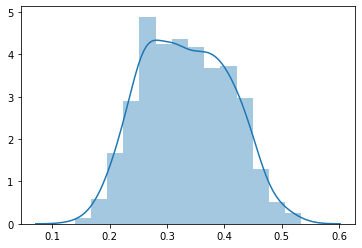

In [264]:
sns.distplot(y_predict)
plt.show()